# MCMC sampling diagnostics

In this notebook, we illustrate how to assess the quality of your MCMC samples, e.g. convergence and auto-correlation, in pyPESTO.

## The pipeline

First, we load the model and data to generate the MCMC samples from. In this example we show a toy example of a conversion reaction, loaded as a [PEtab](https://github.com/petab-dev/petab) problem.

In [1]:
import pypesto
import pypesto.petab
import pypesto.optimize as optimize
import pypesto.sample as sample
import pypesto.visualize as visualize

import petab
import numpy as np
import logging
import matplotlib.pyplot as plt

# log diagnostics
logger = logging.getLogger("pypesto.sample.diagnostics")
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

# import to petab
petab_problem = petab.Problem.from_yaml(
    "conversion_reaction/multiple_conditions/conversion_reaction.yaml")
# import to pypesto
importer = pypesto.petab.PetabImporter(petab_problem)
# create problem
problem = importer.create_problem()

Create the sampler object, in this case we will use adaptive parallel tempering with 3 temperatures.

In [2]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(),
    n_chains=3)

First, we will initiate the MCMC chain at a "random" point in parameter space, e.g. $\theta_{start} = [3, -4]$

In [3]:
result = sample.sample(problem, n_samples=10000, sampler=sampler, x0=np.array([3,-4]))
elapsed_time = result.sample_result.time
print(f'Elapsed time: {round(elapsed_time,2)}')

100%|██████████| 10000/10000 [00:55<00:00, 178.85it/s]

Elapsed time: 67.62


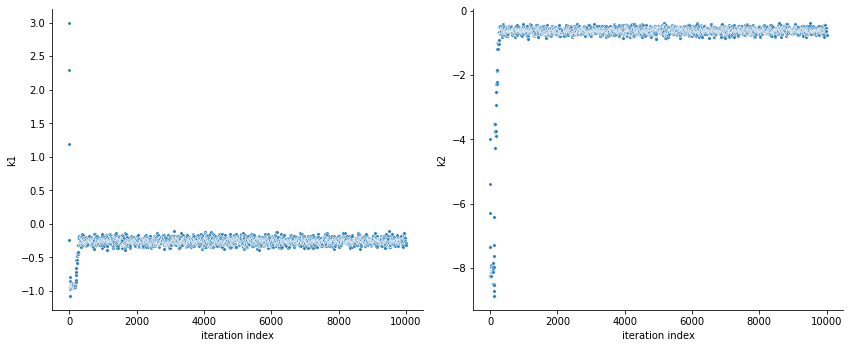

In [4]:
ax = visualize.sampling_parameter_traces(result, use_problem_bounds=False, size=(12,5))

By visualizing the chains, we can see a warm up phase occurring until convergence of the chain is reached. This is commonly known as "burn in" phase and should be discarded. An automatic way to evaluate and find the index of the chain in which the warm up is finished can be done by using the Geweke test.

Geweke burn-in index: 500


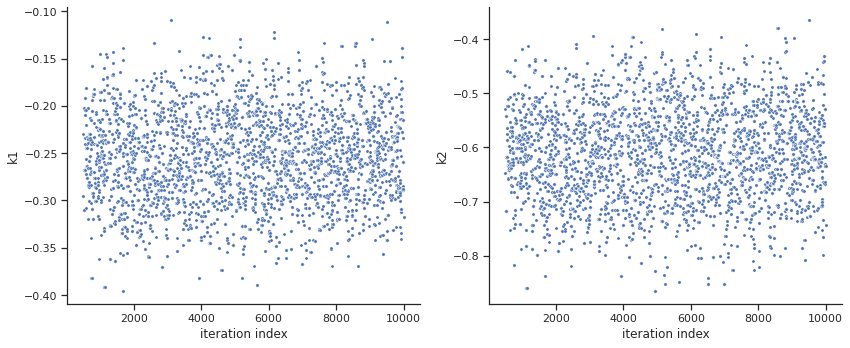

In [5]:
sample.geweke_test(result=result)
ax = visualize.sampling_parameter_traces(result, use_problem_bounds=False, size=(12,5))

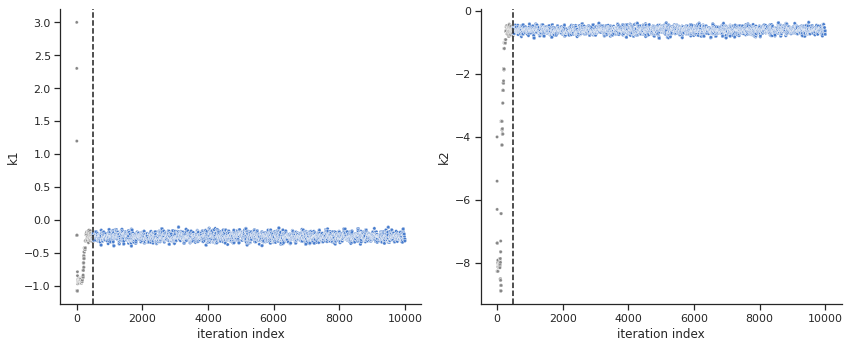

In [6]:
ax = visualize.sampling_parameter_traces(result, use_problem_bounds=False, full_trace=True, size=(12,5))

Calculate the effective sample size per computation time. We save the results in a variable as we will compare them later.

In [7]:
sample.effective_sample_size(result=result)
ess = result.sample_result.effective_sample_size
print(f'Effective sample size per computation time: {round(ess/elapsed_time,2)}')

Estimated chain autocorrelation: 7.804687098609438
Estimated effective sample size: 1079.0843437809997


Effective sample size per computation time: 15.96


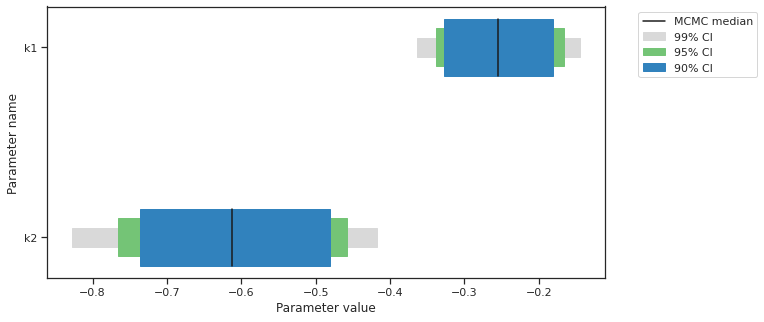

In [8]:
alpha = [99, 95, 90]
ax = visualize.sampling_parameter_cis(result, alpha=alpha, size=(10,5))

Predictions can be performed by creating a parameter ensemble from the sample, then applying a predictor to the ensemble. The predictor requires a simulation tool. Here, [AMICI](https://github.com/AMICI-dev/AMICI) is used. First, the predictor is setup.

In [9]:
from pypesto.predict.constants import AMICI_STATUS, AMICI_T, AMICI_X, AMICI_Y
from pypesto.predict import AmiciPredictor


# This post_processor will transform the output of the simulation tool
# such that the output is compatible with the next steps.
def post_processor(amici_outputs, output_type, output_ids):
    outputs = [
        amici_output[output_type] if amici_output[AMICI_STATUS] == 0
        else np.full((len(amici_output[AMICI_T]), len(output_ids)), np.nan)
        for amici_output in amici_outputs
    ]
    return outputs


# Setup post-processors for both states and observables.
from functools import partial
amici_objective = result.problem.objective
state_ids = amici_objective.amici_model.getStateIds()
observable_ids = amici_objective.amici_model.getObservableIds()
post_processor_x = partial(
    post_processor,
    output_type=AMICI_X,
    output_ids=state_ids,
)
post_processor_y = partial(
    post_processor,
    output_type=AMICI_Y,
    output_ids=observable_ids,
)

# Create pyPESTO predictors for states and observables
predictor_x = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_x,
    output_ids=state_ids,
)
predictor_y = AmiciPredictor(
    amici_objective,
    post_processor=post_processor_y,
    output_ids=observable_ids,
)

Next, the ensemble is created.

In [10]:
from pypesto.ensemble import Ensemble, EnsembleType

# corresponds to only the estimated parameters
x_names = result.problem.get_reduced_vector(result.problem.x_names)

# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    result,
    chain_slice=slice(None, None, 2),
    x_names=x_names,
    ensemble_type=EnsembleType.sample,
    lower_bound=result.problem.lb,    
    upper_bound=result.problem.ub
)

The predictor is then applied to the ensemble to generate predictions.

In [11]:
from pypesto.engine import MultiProcessEngine

# Note that parallelizing the prediction calculations can result
# in longer runtimes, due to serialization.
engine = None
#engine = MultiProcessEngine()

ensemble_prediction = ensemble.predict(predictor_x, prediction_id=AMICI_X, engine=engine)

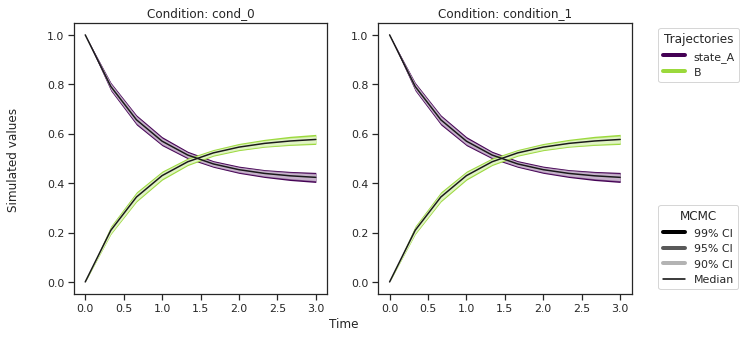

In [12]:
from pypesto.predict.constants import CONDITION, OUTPUT

credibility_interval_levels = [90, 95, 99]

ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10,5),
    labels={'A': 'state_A', 'condition_0': 'cond_0'},
    axis_label_padding=60,
    groupby=CONDITION,
    condition_ids=['condition_0', 'condition_1'],  # `None` for all conditions
    output_ids=['A', 'B'],  # `None` for all outputs
)

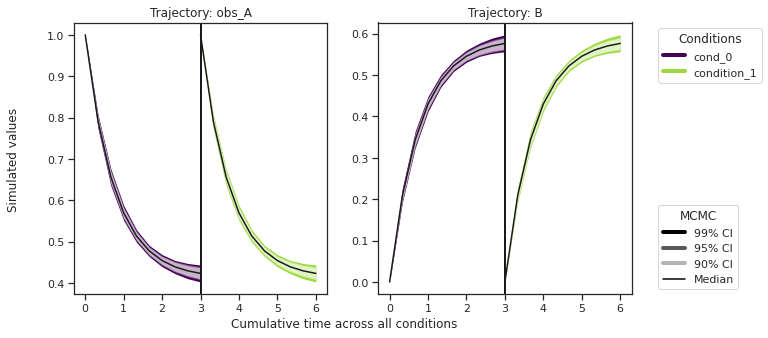

In [13]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10,5),
    labels={'A': 'obs_A', 'condition_0': 'cond_0'},
    axis_label_padding=60,
    groupby=OUTPUT,
)

Predictions are stored in `ensemble_prediction.prediction_summary`.

### Commonly, as a first step, optimization is performed, in order to find good parameter point estimates.

In [14]:
res = optimize.minimize(problem, n_starts=10)

By passing the result object to the function, the previously found global optimum is used as starting point for the MCMC sampling.

In [15]:
res = sample.sample(problem, n_samples=10000, sampler=sampler, result=res)
elapsed_time = res.sample_result.time
print('Elapsed time: '+str(round(elapsed_time,2)))

100%|██████████| 10000/10000 [00:59<00:00, 167.71it/s]

Elapsed time: 72.13


When the sampling is finished, we can analyse our results. pyPESTO provides functions to analyse both the sampling process as well as the obtained sampling result. Visualizing the traces e.g. allows to detect burn-in phases, or fine-tune hyperparameters. First, the parameter trajectories  can be visualized:

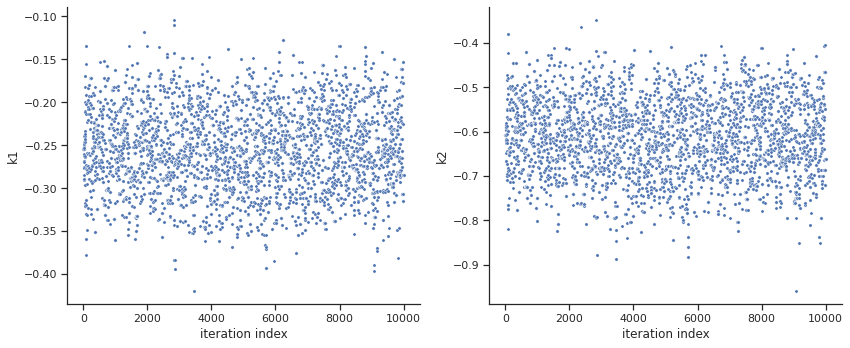

In [16]:
ax = visualize.sampling_parameter_traces(res, use_problem_bounds=False, size=(12,5))

By visual inspection one can see that the chain is already converged from the start. This is already showing the benefit of initiating the chain at the optimal parameter vector. However, this may not be always the case.

Geweke burn-in index: 0


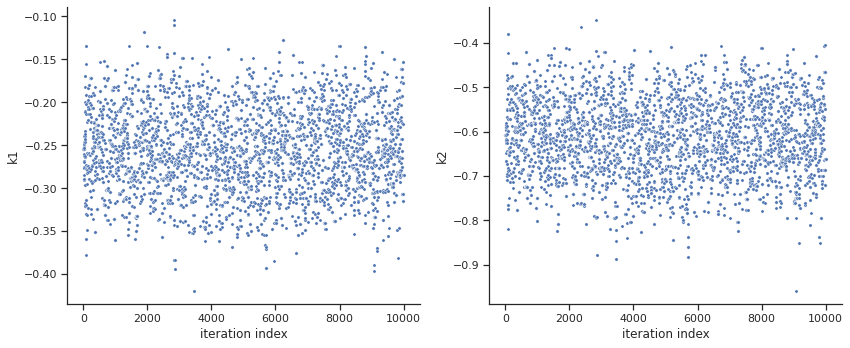

In [17]:
sample.geweke_test(result=res)
ax = visualize.sampling_parameter_traces(res, use_problem_bounds=False, size=(12,5))

In [18]:
sample.effective_sample_size(result=res)
ess = res.sample_result.effective_sample_size
print(f'Effective sample size per computation time: {round(ess/elapsed_time,2)}')

Estimated chain autocorrelation: 8.893688812287204
Estimated effective sample size: 1010.8464284402723


Effective sample size per computation time: 14.01


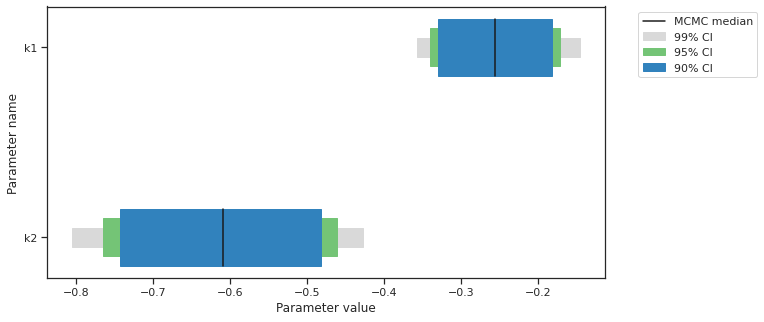

In [19]:
percentiles = [99, 95, 90]
ax = visualize.sampling_parameter_cis(res, alpha=percentiles, size=(10,5))

In [20]:
# Create the ensemble with the MCMC chain from parallel tempering with the real temperature.
ensemble = Ensemble.from_sample(
    res,
    x_names=x_names, 
    ensemble_type=EnsembleType.sample,
    lower_bound=res.problem.lb,    
    upper_bound=res.problem.ub
)

ensemble_prediction = ensemble.predict(predictor_y, prediction_id=AMICI_Y, engine=None)

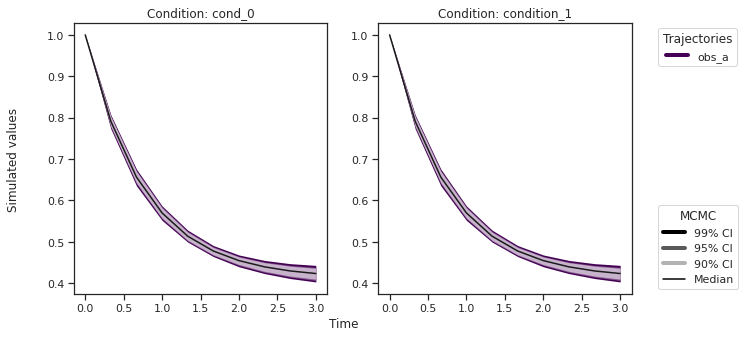

In [21]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10,5),
    labels={'A': 'obs_A', 'condition_0': 'cond_0'},
    axis_label_padding=60,
    groupby=CONDITION,
)

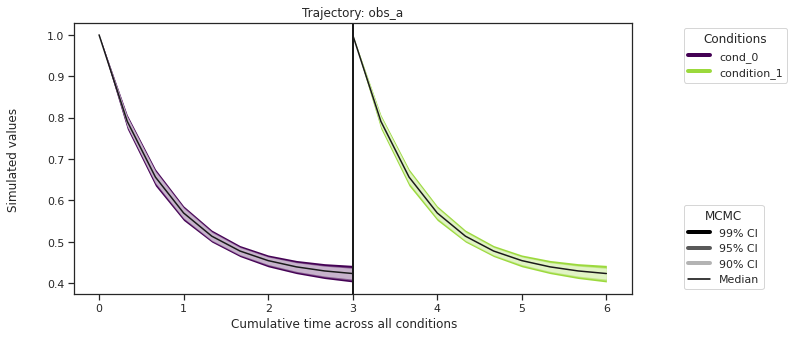

In [22]:
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    size=(10,5),
    labels={'A': 'obs_A', 'condition_0': 'cond_0'},
    axis_label_padding=60,
    groupby=OUTPUT,
)

Custom timepoints can also be specified, either for each condition
- `amici_objective.custom_timepoints(..., timepoints=...)`

or for all conditions
- `amici_objective.custom_timepoints(..., timepoints_global=...)`.

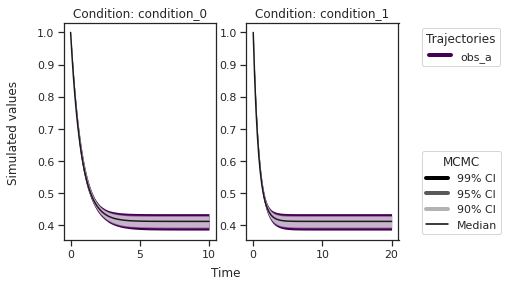

In [23]:
# Create a custom objective with new output timepoints.
timepoints = [np.linspace(0, 10, 100), np.linspace(0, 20, 200)]
amici_objective_custom = amici_objective.custom_timepoints(timepoints=timepoints)

# Create an observable predictor with the custom objective.
predictor_y_custom = AmiciPredictor(
    amici_objective_custom,
    post_processor=post_processor_y,
    output_ids=observable_ids,
)

# Predict then plot.
ensemble_prediction = ensemble.predict(predictor_y_custom, prediction_id=AMICI_Y, engine=None)
ax = visualize.sampling_prediction_trajectories(
    ensemble_prediction,
    levels=credibility_interval_levels,
    groupby=CONDITION,
)